In [1]:
import subprocess
import ProgressBar as pb
import shutil
import os

### Script to run the future landcover and future forcings experiment

- Loop through years: 2000, 2050, 2100
- Loop through forcings: PGW_lessPrecip and PGW_morePrecip
- Loop through the landcover scenarions pertinaint to each forcing class:
    - PGW_lessPrecip: Scenarios 1,2,5
    - PGW_morePrecip: Scenarios 1,2,3
    
Write a script such that the correct forcings are served to the correct model instances

changes to be made: 
- lc w/o pgw and precip
- 

In [2]:
params = pd.read_pickle('./data/experiment_forcing_params_dynamic.pcl')
params['idx'] = np.arange(1,len(params)+1)
params.reset_index(inplace=True)

In [3]:
params.shape

(126, 11)

In [4]:
params.tail(24)

,index,P,T,decade,krumlai,krumweight,name,scenarios,track,year,idx
102,0,0.075,2.0,5.0,NaN,NaN,CLC_MP_FT,1,PGW_MP,2000,103
103,1,0.075,2.0,5.0,NaN,NaN,CLC_MP_FT,2,PGW_MP,2000,104
104,2,0.075,2.0,5.0,NaN,NaN,CLC_MP_FT,3,PGW_MP,2000,105
105,3,0.150,4.0,10.0,NaN,NaN,CLC_MP_FT,1,PGW_MP,2000,106
106,4,0.150,4.0,10.0,NaN,NaN,CLC_MP_FT,2,PGW_MP,2000,107
107,5,0.150,4.0,10.0,NaN,NaN,CLC_MP_FT,3,PGW_MP,2000,108
108,0,0.075,2.0,5.0,NaN,NaN,CLC_MP_FT,1,PGW_LP,2000,109
109,1,0.075,2.0,5.0,NaN,NaN,CLC_MP_FT,2,PGW_LP,2000,110
110,2,0.075,2.0,5.0,NaN,NaN,CLC_MP_FT,5,PGW_LP,2000,111
111,3,0.150,4.0,10.0,NaN,NaN,CLC_MP_FT,1,PGW_LP,2000,112


In [5]:
# contract the params to only run the last 12 simulations
#params = params.tail(24)

In [6]:
params.shape

(126, 11)

In [7]:
# set up the parallel environemnt
import ipyparallel as p

c = p.Client()
view = c.load_balanced_view()
c.ids

[0, 1, 2, 3, 4, 5, 6, 7]

In [8]:
%%px
import subprocess
import shutil
import os

In [9]:
# set calibrated parameters from opt 23 run 180
#gw1 = 0.348374
#gw2 = 0.701333
#m = 17.758708
#ksat = 214.275801
#pa = 26.750008
#po = 9.758069

# from opt 23 389
#gw1 = 0.277932
#gw2 = 0.371005
#m = 5.687163
#ksat = 32.976835
#pa = 17.179477
#po = 13.027247

# from opt 26 1187 - changed the experiment worldfile to the correct soil file!
#gw1 = 0.244624
#gw2 = 0.997174
#m = 13.936816
#ksat = 502.160744
#pa = 746.478663
#po = 12.591981

#crd = 11.877791 
#trd = 3.711013

In [20]:
def run_exp(idx,year,track,scen,dec,name):
    '''
    Inputs:
    idx - simulation indexer
    year - simulation year
    track - simulation track
    scen - simulation scenario
    dec - simulation decade
    name - experiment designator 
    
    Outputs:
    idx - simulation indexer
    ouput - RHESSys commandline output
    
    works with worldfles that look like:
    
    PGW_LP_R1_2000.world.lai where:
    
    PGW_LP == simulation track
    R1 == simulation scenario 
    2000 == simulation year
    
    works with climate files that look like:
    
    grid60_PGW_LP_1_2000_10_CLC_MP_CT where:
    
    grid60 == meteorology grid cell size
    PGW_LP == simulation track 
    1 == simulation scenario
    2000 == simulation year
    10 == simulation decade
    CLC_MP_CT == experiment designator (i.e. Current Land Cover, More Precipitation, Current Temperature)
    '''
    print idx
    print year
    print track
    print scen
    print dec
    print name
    
    # set start and end dates
    strt = '1990 10 1 1'
    nd = '2013 10 5 1' # 2013 10 5 1 # use long date for real experiment, short date for
    # extracting effective precipitation
    
    # from opt 40 1364
    gw1 = 0.431707
    gw2 = 0.168340
    m = 24.052533
    ksat = 122.731664
    pa = 804.935265
    po = 3.570694
    minrain = -2.561700
    maxsnow = 3.032986
    msed = -78.335363
    smtc = 0.176698
    crd = 0.577681 # these are in the worldfile
    trd = 0.033624 # these are in the worldfile
    sd = 0.601265
    a = 0.115062
    b = 20.12204
    c = 0.623436
    maxflow = 20
    
    # make a temporary directory for the worldfile header and the climate basestation
    newdir = '/RHESSys/Como/tmp/%s'%(idx)
    if not os.path.exists(newdir):
        os.makedirs(newdir)
    #subprocess.call('mkdir /RHESSys/Como/tmp/%s'%(idx),shell=True)
    #subprocess.call('cp /RHESSys/Como/clim/exp/grid60_exp_base /RHESSys/Como/tmp/%s/'%(idx),shell=True)
    #subprocess.call('cp /RHESSys/Como/worldfiles/exp/world.como.grid60_exp.hdr /RHESSys/Como/tmp/%s/'%(idx),shell=True)
    
    # change and move the climate basestation
    climprefix = '/RHESSys/Como/clim/exp/grid60_%s_%s_%i_%i_%s'%(track,scen,year,dec,name) #climate prefix for the run
    awk = '/RHESSys/Como/scripts/change_daily_clim.awk'
    basein = '/RHESSys/Como/clim/exp/grid60_exp_base'
    baseout = '/RHESSys/Como/tmp/%s/grid60_exp_basestation'%(idx) # put the basestation file in the new folder
    cmd = 'awk -f %s < %s par=%s > %s'%(awk,basein,climprefix,baseout)
    subprocess.call(cmd,shell=True)
    print 'climate basestation edited'
    
    # change the header to point to the correct basestation file
    climpath = '/RHESSys/Como/tmp/%s/grid60_exp_basestation'%(idx)
    awk = '/RHESSys/Como/scripts/change_header_clim.awk'
    hdrin = '/RHESSys/Como/worldfiles/exp/world.como.grid60_exp.hdr'
    hdrout = '/RHESSys/Como/tmp/%s/world.como.grid60_exp.hdr'%(idx) # put the header in the new folder
    cmd = 'awk -f %s < %s par=%s > %s'%(awk,hdrin,climpath,hdrout)
    subprocess.call(cmd,shell=True)
    print 'header file edited'
    
    # select the correct worldfile
    w = '/RHESSys/Como/worldfiles/exp/%s_R%s_%s.world.lai'%(track,scen,year)
    print w
    out = '/RHESSys/Como/out/exp/%s_%s_%i_%i_%s_%i'%(track,scen,year,dec,name,idx) # for local output
    #out = '/Volumes/hydroData/Theo/RHESSys/out/exp/%s_%s_%i_%i_%s_%i'%(track,scen,year,dec,name,idx) # for spatial output
    print out
    hdr = '/RHESSys/Como/tmp/%s/world.como.grid60_exp.hdr'%(idx)
    print hdr
    f = '/RHESSys/Como/flowtables/como.flow'
    t = '/RHESSys/Como/tecfiles/exp.tec'
    
    # change the snow parameterization
    
    # build the command, remove -p for non-spatial output
    cmd = 'rhessys5.196 -w %s -whdr %s -t %s -b -s %s %s %s -sv %s %s -gw %s %s -pre %s -st %s -ed %s -asciigrid -r %s -svalt %s %s'%(w,
            hdr,t,m,ksat,m,ksat,sd,gw1,gw2,out,strt,nd,f,po,pa)
    
    print cmd
    
    output = subprocess.check_output(cmd,shell=True) # run the command
    
    # apply the leakage code
    cmd = 'python /RHESSys/Como/scripts/leakage.py %s_basin.daily %s %s %s %s'%(out,a,b,c,maxflow)
    print cmd
    subprocess.call(cmd, shell = True)
    
    shutil.rmtree(newdir) 
    return idx,output

In [21]:
# test case for timing
num = 8
res = view.map(run_exp,params.idx[0:num],params.year[0:num],params.track[0:num],params.scenarios[0:num],
               params.decade[0:num],params.name[0:num])

In [32]:
res = view.map(run_exp,params.idx,params.year,params.track,params.scenarios,
               params.decade,params.name)

In [33]:
res.progress

126

In [34]:
res.ready()

True

In [28]:
res.done()

True

In [35]:
res.elapsed/60./60.

27.72667846027778

## Get Effective Precipitation

Use the RHESSys output to get effective precipitation from each run

In [30]:
res.result()

[(1,
  'Setting climate mode to gridded ascii\nReading specified world file header /RHESSys/Como/tmp/1/world.como.grid60_exp.hdr\nOpening climate grid /RHESSys/Como/tmp/1/grid60_exp_basestation\nReading /RHESSys/Como/defs/basin.def\nReading /RHESSys/Como/defs/hill.def\nReading /RHESSys/Como/defs/zone.def\nReading /RHESSys/Como/defs/sandyloam.def\n\nNote that soil depth used for biogeochem cycling (active zone z)\nis more than 0.5 meter different from hydrologic soil depth\nfor soil default file: /RHESSys/Como/defs/sandyloam.def\n\n Sensitivity analysis giving Pore Size Index > 1.0, not allowed, setting to 1.0\nReading /RHESSys/Como/defs/alpine.def\nReading /RHESSys/Como/defs/forest.def\nReading /RHESSys/Como/defs/veg_evergreen.def\nReading /RHESSys/Como/defs/veg_grass_tbb.def\n\nConstructed fire defaults\n\nConstructing base stations from ASCII GRID\nYou have 5146 base stations \nDaily clim is /RHESSys/Como/clim/exp/grid60_PGW_LP_1_2000_0_CLC_CP_CT \nOpened tmax file /RHESSys/Como/clim

In [13]:
idx,mes = zip(*res.result())

In [14]:
dat = pd.DataFrame({'idx':idx,'message':mes})

In [15]:
message = dat['message'][0]

In [16]:
def get_effective_precip(message):
    return float(message.split('is')[-2].split('\n')[0])

In [17]:
dat['effective_precip'] = dat.message.map(get_effective_precip)

In [18]:
dat = pd.merge(dat,params,on='idx')

In [19]:
dat

,idx,message,effective_precip,forcing,scenario,track,year
0,1,\n Running wiith snow redistributionSetting cl...,0.941938,1,1,PGW_MP,2000
1,2,\n Running wiith snow redistributionSetting cl...,0.940829,2,1,PGW_LP,2000
2,3,\n Running wiith snow redistributionSetting cl...,0.940551,1,2,PGW_MP,2000
3,4,\n Running wiith snow redistributionSetting cl...,0.940987,2,2,PGW_LP,2000
4,5,\n Running wiith snow redistributionSetting cl...,0.941066,1,3,PGW_MP,2000
5,6,\n Running wiith snow redistributionSetting cl...,0.941938,2,5,PGW_LP,2000
6,7,\n Running wiith snow redistributionSetting cl...,0.964727,3,1,PGW_MP,2050
7,8,\n Running wiith snow redistributionSetting cl...,0.968492,4,1,PGW_LP,2050
8,9,\n Running wiith snow redistributionSetting cl...,0.972138,3,2,PGW_MP,2050
9,10,\n Running wiith snow redistributionSetting cl...,0.960724,4,2,PGW_LP,2050


In [20]:
import seaborn as sns

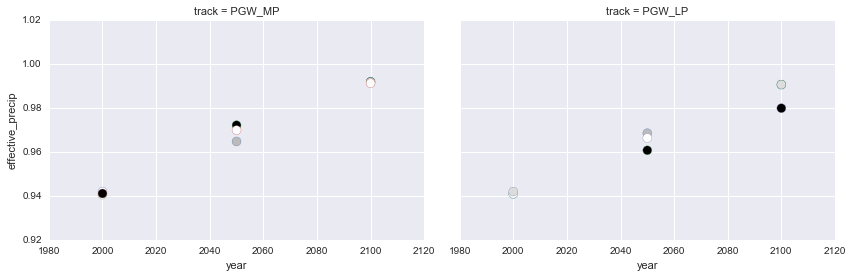

In [23]:
g = sns.FacetGrid(dat,col='track',hue='scenario',aspect=1.5,size=4)
g = g.map(plt.scatter,'year','effective_precip',s=80)

In [54]:
# summarize by track and year.
dat.groupby(by=['track','year']).mean().round(2)

idx  effective_precip  forcing  scenario
track  year                                           
PGW_LP 2000   4.0              0.94      2.0      2.67
       2050  10.0              0.97      4.0      2.67
       2100  16.0              0.99      6.0      2.67
PGW_MP 2000   3.0              0.94      1.0      2.00
       2050   9.0              0.97      3.0      2.00
       2100  15.0              0.99      5.0      2.00